In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense , Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import save_model, load_model



In [45]:
df = pd.read_csv('resourcesxxx.csv')

# Extract features and target
X = df.drop(columns=['DataCenterID'])
y = df['DataCenterID']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

noise_factor = 0.05  # You can adjust this parameter based on your needs
X_noisy = X_scaled + noise_factor * np.random.normal(size=X_scaled.shape)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_noisy, y, test_size=0.2, random_state=42)
print(X.shape)
print(X.iloc[1])


(900, 14)
TaskID                       12.00
StartTime                     0.10
TaskFileSize                 62.00
TaskOutputFileSize           18.00
TaskFileLength               17.00
DistanceFromDataCenter    10168.00
DataCenterCpuCost            12.00
DataCenterRamCost            10.00
DataCenterStorageCost         2.00
DataCenterBwCost              1.00
DataCenterTotalLoad       16327.00
NetworkDelay                  1.16
CET                         718.00
ObjectiveFunction         11837.11
Name: 1, dtype: float64


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [29]:
# Reshape data for LSTM input (assuming a time series sequence length of 1)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_lstm = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
print(X_train_lstm[1])
# Define the LSTM model
model = Sequential()
from keras.regularizers import l2

model.add(LSTM(units=50, input_shape=(1, X_train.shape[1]), return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=len(df['DataCenterID'].unique()), activation='softmax'))
model.add(Dropout(0.5))
num_classes = len(df['DataCenterID'].unique())
model.add(Dense(units=num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])


[[-0.9120923  -0.29304042 -0.82238969 -0.73501241 -0.53149879  0.66886263
  -1.01515877  1.31764899 -0.75977462 -1.47512645  1.00634964 -0.79156272
  -0.99091673 -0.56128121]]
Epoch 1/20
23/23 [==============================] - 6s 66ms/step - loss: 1.1192 - accuracy: 0.3319 - val_loss: 1.0943 - val_accuracy: 0.3111
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 1.0905 - accuracy: 0.3861 - val_loss: 1.0500 - val_accuracy: 0.6278
Epoch 3/20
23/23 [==============================] - 0s 7ms/step - loss: 1.0313 - accuracy: 0.4264 - val_loss: 0.9628 - val_accuracy: 0.6556
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 0.9713 - accuracy: 0.4111 - val_loss: 0.8914 - val_accuracy: 0.6778
Epoch 5/20
23/23 [==============================] - 0s 9ms/step - loss: 0.9062 - accuracy: 0.5139 - val_loss: 0.8458 - val_accuracy: 0.6778
Epoch 6/20
23/23 [==============================] - 0s 9ms/step - loss: 0.8805 - accuracy: 0.5694 - val_loss: 0.8182 - val

In [30]:

# Assuming you have your X_test and y_test prepared similarly to X_train and y_train
X_test_lstm = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_lstm, y_val)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)
# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
print(X_test_lstm.shape)
print(X_test_lstm[1])

6/6 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 1.0000
Test Loss: 0.5428
Test Accuracy: 100.00%
6/6 [==============================] - 1s 5ms/step
(180, 1, 14)
[[ 1.54219933  0.68110256  0.91907866  1.31762261 -1.08799205  1.59331108
   1.42833514 -0.93912855 -0.69774369  0.62223205 -1.50330198 -0.59462759
   0.55960089  0.25098257]]



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        58

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



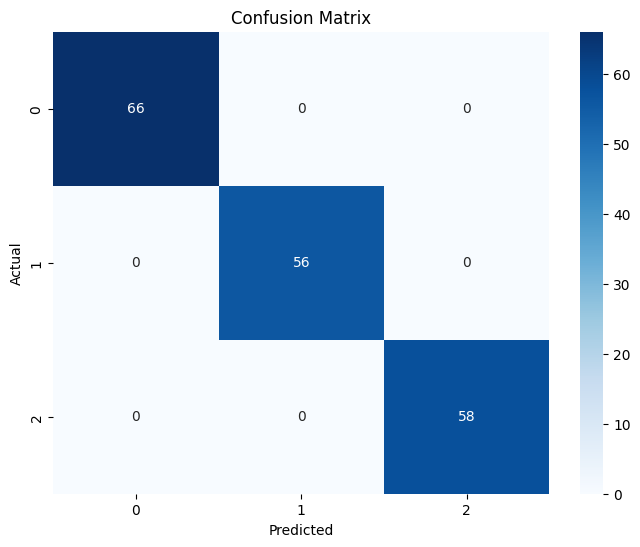

In [18]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes))

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Create a colorful confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [64]:

# Save the model
model.save('lstm64.keras')

# Load the saved model
loaded_model = load_model('lstm64.keras')

# Assuming input_data is a NumPy array
input_data = np.array([[0.1, 55, 0, 0, 0, 0, 0, 0, 0, 0, 5000, 1.16, 718, 22.11]])

# Reshape the input data to match the LSTM input shape
input_data_lstm = input_data.reshape(input_data.shape[0], 1, input_data.shape[1])

# Make predictions using the loaded model
predicted_probabilities = loaded_model.predict(input_data_lstm)
predicted_class = np.argmax(predicted_probabilities, axis=1)

print(f"Predicted DataCenterID: {predicted_class[0]}")


1/1 [==============================] - 1s 1s/step
Predicted DataCenterID: 2
